In [1]:
import pandas as pd
import numpy as np
import math
import pandas_datareader as pdd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
aboitizdt = pdd.DataReader('ABTZY', data_source='yahoo', start='2020-01-01', end = '2022-10-10')
aboitizdt

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-12-31,11.06,11.06,11.06,11.06,0.0,10.257041
2020-01-02,11.06,11.06,11.06,11.06,0.0,10.257041
2020-01-03,11.06,11.06,11.06,11.06,0.0,10.257041
2020-01-06,11.06,11.06,11.06,11.06,0.0,10.257041
2020-01-07,11.06,11.06,11.06,11.06,0.0,10.257041
...,...,...,...,...,...,...
2022-10-03,9.73,9.73,9.73,9.73,0.0,9.730000
2022-10-04,9.73,9.73,9.73,9.73,0.0,9.730000
2022-10-05,9.73,9.73,9.73,9.73,0.0,9.730000


In [3]:
# Take a look at the data
aboitizdt.head

<bound method NDFrame.head of              High    Low   Open  Close  Volume  Adj Close
Date                                                     
2019-12-31  11.06  11.06  11.06  11.06     0.0  10.257041
2020-01-02  11.06  11.06  11.06  11.06     0.0  10.257041
2020-01-03  11.06  11.06  11.06  11.06     0.0  10.257041
2020-01-06  11.06  11.06  11.06  11.06     0.0  10.257041
2020-01-07  11.06  11.06  11.06  11.06     0.0  10.257041
...           ...    ...    ...    ...     ...        ...
2022-10-03   9.73   9.73   9.73   9.73     0.0   9.730000
2022-10-04   9.73   9.73   9.73   9.73     0.0   9.730000
2022-10-05   9.73   9.73   9.73   9.73     0.0   9.730000
2022-10-06   9.73   9.73   9.73   9.73     0.0   9.730000
2022-10-07   9.73   9.73   9.73   9.73     0.0   9.730000

[699 rows x 6 columns]>

In [4]:
# Check the column headings
# We will use Adj Close for our training data.
aboitizdt.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

<AxesSubplot:xlabel='Date'>

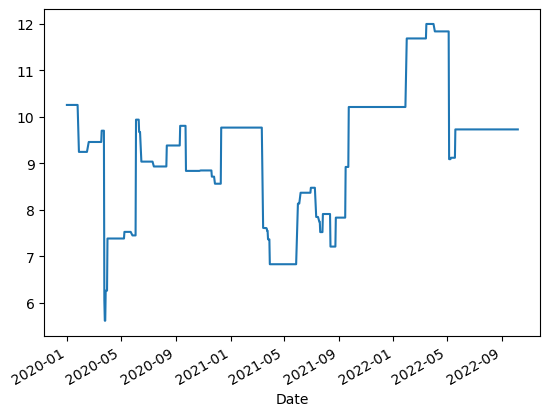

In [5]:
# Slice out the Adj Close column for our study.
# Take a look at the data.
y = aboitizdt['Adj Close']
y.index=aboitizdt.index
y.plot()

In [6]:
# Convert Pandas series to numpy ndarray for further processing.
y = y.values

In [7]:
# Split data into trainning and testing using 80/20 ratio.
training_size = int(y.size * 0.8)
print(training_size)

559


In [8]:
# Data normalization using training data's mean and standard deviation.
# y is a ndarray now and its dimension is 1.
training_mean = y[:training_size].mean()
training_std = y[:training_size].std()
# standarize the data
y = (y-training_mean)/training_std

In [9]:
# Take a look at the training data
y[0:5]

array([0.93668104, 0.93668104, 0.93668104, 0.93668104, 0.93668104])

In [10]:
# Define a function to prepare data.
# The time series data are reorganized to form feature vectors and target values.
# For example, let sHistory be 10. A datapoint as a target will have 10 immediately 
# previous 10 values in the time series for its feature vector. 
def data_preprocess(dataset, iStart, iEnd, sHistory):
  data = []
  target = []
  # begin with sHistory to have historical data
  iStart += sHistory
  if iEnd is None:
    iEnd = len(dataset)
  for i in range(iStart, iEnd):
    indices = range(i-sHistory, i)
    data.append(np.reshape(dataset[indices], (sHistory, 1)))
    target.append(dataset[i])
  return np.array(data), np.array(target)

In [11]:
# Let's define number of history data for training and split data into training nd testing datasets.
past_history = 10
xtrain, ytrain = data_preprocess(y, 0, training_size, past_history)
xtest, ytest = data_preprocess(y, training_size, None, past_history)

In [12]:
# Take a look at data.
xtest[0]

array([[2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652]])

In [13]:
# Take a look at data.
xtest[1]

array([[2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.27795652],
       [2.15483035]])

In [14]:
# It's time to get Tensorflow library in and create an LSTM model.
import tensorflow as tf
# Setting seed to ensure reproducibility.
tf.random.set_seed(8888)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(8, input_shape=xtrain.shape[-2:]),
  tf.keras.layers.Dense(1)
])

In [15]:
# Take a look at the model you have just created.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8)                 320       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 329
Trainable params: 329
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Before taining, you need to configure the model for training.
model.compile(optimizer='Adam',
              loss='mse')

In [17]:
BATCH_SIZE = 16
BUFFER_SIZE = 10000

p_train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
p_train = p_train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

p_test = tf.data.Dataset.from_tensor_slices((xtest, ytest))
p_test = p_test.batch(BATCH_SIZE).repeat()

In [18]:
# For your model to be able to predict something, your need to train your model using training data.
history = model.fit(p_train, epochs = 10, steps_per_epoch=200, validation_data=p_test, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 6s 11ms/step - loss: 0.2695 - val_loss: 0.1918
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1088 - val_loss: 0.0915
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0776 - val_loss: 0.0910
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0651 - val_loss: 0.0876
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0648 - val_loss: 0.0830
Epoch 6/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0547 - val_loss: 0.0725
Epoch 7/10
200/200 [==============================] - 4s 23ms/step - loss: 0.0528 - val_loss: 0.0686
Epoch 8/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0502 - val_loss: 0.0592
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0464 - val_loss: 0.0544
Epoch 10/10
200/200 [==============================] - 4s 20ms/step - loss: 0.0457 - val_loss: 0

In [19]:
# Convert training history to datafram for viewing and graphing.
hist = pd.DataFrame(history.history)
hist.head()

,loss,val_loss
0,0.269493,0.191811
1,0.108773,0.091461
2,0.077558,0.090980
3,0.065085,0.087561
4,0.064824,0.083043


<AxesSubplot:>

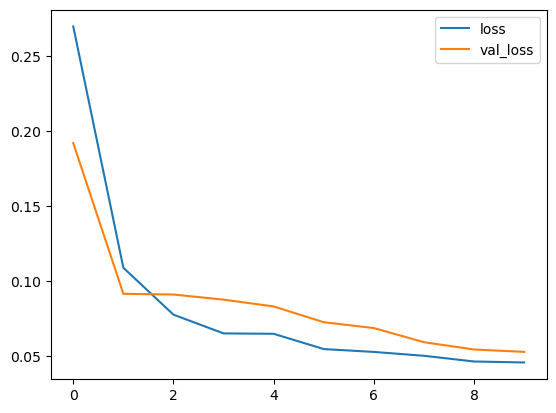

In [20]:
# Training errors with respect to ecochs.
# loss: values of the cost function for training data.
# val_loss: values of the cost function for cross-validation data.
hist.plot()

In [21]:
# Now, we can predict stock values after model is trained. 
# We keep the predicted values and target vlaues for graphics later.
# You may run on p_train or p_test to check the preformance.
predicted_value = []
y_orig = []
count =0;
for x, y in p_train.take(20):
  y_orig.append(y[0].numpy())
  t_pred= model.predict(x)
  predicted_value.append(t_pred[0])

1/1 [==============================] - 0s 18ms/step


<AxesSubplot:>

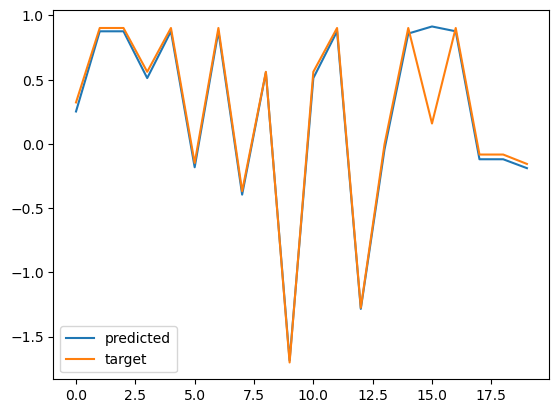

In [22]:
# Plot the predicted value and the target values together.
y_pred = [predicted_value[i][0] for i in range(len(predicted_value))]
result = pd.DataFrame({'predicted':y_pred, 'target':y_orig})
result.plot()